# Calculating features

Training a neural network from scratch takes a lot of computational resources and enough, roughly balanced training data. Alternatively, one can use a __pretrained__ neural network and use it as a __feature extractor__.
`Keras` offers multiple pretrained models, that are mostly trained on imagenet, a database of natural images from 1000 classes.

This notebook loads such a model, removes its classification layer and adds a pooling layer such that the output is a feature vector instead of a classification result. These features are later going to be classified with a "non-deep" approach, such as an SVM or RF.

A set of features is stored as Pandas Dataframe with columns `id`, `label` and `features`. 

Again, __every region is treated separately__, i.e. gets its own dataframe of features and its own pickle file.
This might seem a little impractical and clumsy but has two advantages in this context:

1. Feature calculation is of course faster on smaller subsets. When trying new models or new parameters, features can be computed on a region with few roofs first.
2. Datasets are have different classification "difficulties". E.g. `mixco_3` is a small set that has no "incomplete" or "other" samples and only correctly labeled data. Thus, the pipeline can be tested on easy and more difficult sets.

In [38]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50 #--- good
from keras.applications.resnet50 import preprocess_input
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input
#from keras.applications.vgg16 import VGG16 --- ok-ish
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.xception import Xception --- bad
#from keras.applications.xception import preprocess_input
#from keras.applications.inception_resnet_v2 import InceptionResNetV2 ---ok-ish
#from keras.applications.inception_resnet_v2 import preprocess_input
#from keras.applications.nasnet import NASNetLarge --- bad
#from keras.applications.nasnet import preprocess_input
#from keras.applications.densenet import DenseNet201 #--- good
#from keras.applications.densenet import preprocess_input

import numpy as np
import pandas as pd
from os.path import join
import os

import matplotlib.pyplot as plt

In [39]:
regions = ['borde_rural', 'borde_soacha', 'mixco_1_and_ebenezer', 'mixco_3']

In [48]:
region = 'mixco_3'
train_dir = join('..', '..', 'data', 'data2', region, 'roofs_train')
test_dir = join('..', '..', 'data', 'data2', region, 'roofs_test')
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

Use a pretrained network to compute features from the images, which are later classified. Import the model from the Keras library and remove the top layer by setting `include_top=False`. The last layer is pooled such that we get outputs of size 1x2048 (for ResNet50) instead of 7x7x2048. The pooling method `'max'` is chosen empirically.

## 1. Load the model

In [49]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg', classes=1000)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

## 2. Calculate features on the training data

The preprocessed data is stored in such a way, that every region has their own folder, that contains a subfolder defined as `train_dir` above. This folder again is subdivided by material. Images carry their `id` as filename.

Traverse all images in their corresponding folders which indicate the material and use `model.predict()` to get the features.

In [50]:
def calculate_features_train(train_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features', 'label']
    df_features = pd.DataFrame(columns=columns)
    
    data = []

    # Walk through all images
    for material in materials.keys():
        material_fp = join(train_dir, material)
        for root, dirs, files in os.walk(material_fp):
            for file in files:
                img_fp = join(material_fp, file)
                label = materials[material]
                id = file.split('.')[0]
                print(id, "labeled as", material, ":", label)

                # Pad if size is too small, preprocess
                img = image.load_img(img_fp, target_size=(224, 224))
                img_data = image.img_to_array(img)
                #plt.imshow(img_data, vmin=0, vmax=1)
                img_data = np.expand_dims(img_data, axis=0)
                img_data = preprocess_input(img_data)

                # Compute features 
                features = model.predict(img_data)
                features_np = np.array(features).flatten()

                data.append({'id': id ,
                             'features': features_np,
                             'label': label})
                #df_features = df_features.append({'id': id ,
                #                                  'features': resnet50_feature_np,
                #                                  'label': label}, ignore_index=True)
    
    df_features = pd.DataFrame(data)
    return df_features

The results are stored in a dataframe as shown below and saved to disk as a pickle file.

In [51]:
print(train_dir)

../../data/data2/mixco_3/roofs_train


In [52]:
features_train = calculate_features_train(train_dir)

7a3afb66 labeled as concrete_cement : 0
7a33dd36 labeled as concrete_cement : 0
7a3ecf2a labeled as concrete_cement : 0
7a2689d8 labeled as concrete_cement : 0
7a3cf704 labeled as concrete_cement : 0
7a37ce64 labeled as concrete_cement : 0
7a35063e labeled as concrete_cement : 0
7a1ed850 labeled as concrete_cement : 0
7a32edd6 labeled as concrete_cement : 0
7a2e79c2 labeled as concrete_cement : 0
7a44445a labeled as concrete_cement : 0
7a43b634 labeled as concrete_cement : 0
7a1d9206 labeled as concrete_cement : 0
7a3e050e labeled as concrete_cement : 0
7a401772 labeled as concrete_cement : 0
7a3acde4 labeled as concrete_cement : 0
7a4410ac labeled as concrete_cement : 0
7a262b96 labeled as concrete_cement : 0
7a2acb1a labeled as concrete_cement : 0
7a25fdec labeled as concrete_cement : 0
7a351f0c labeled as concrete_cement : 0
7a244a56 labeled as concrete_cement : 0
7a1f5cc6 labeled as concrete_cement : 0
7a3b6114 labeled as concrete_cement : 0
7a4226a2 labeled as concrete_cement : 0


In [53]:
features_train.head()

,id,features,label
0,7a3afb66,"[0.022146469, 0.8669851, 0.038466625, 0.039505...",0
1,7a33dd36,"[0.15398781, 1.7262567, 0.05316858, 0.00871692...",0
2,7a3ecf2a,"[0.26490206, 1.4662894, 0.009525318, 0.0, 0.04...",0
3,7a2689d8,"[0.0064946874, 1.5157273, 0.012561305, 0.07286...",0
4,7a3cf704,"[0.0, 1.5875218, 0.081564166, 0.08581044, 0.00...",0


In [54]:
len(features_train.features[0])

2048

Save feature frames as pickles

In [55]:
import pickle
from os import makedirs
from os.path import exists

pickle_path = join('..', '..', 'pickles')
if not exists(pickle_path):
    makedirs(pickle_path)

with open(join(pickle_path, 'resnet50_avg_features_' + region + '_train.pkl' ), 'wb') as f:
    pickle.dump(features_train, f)

### 2.1 Visualize discriminativeness

In order to visualize how well the extracted features discriminate the classes, the dimensionality of the feature vector can be reduced to 2 using the tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [31]:
def plot_tSNE(features, labels=None, number_of_materials=5, title='default_title', path='.'):
    if labels is None:
        labels = np.zeros((features.shape[0]))

    tsne_features = TSNE(n_components=2).fit_transform(features)

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, number_of_materials, number_of_materials + 1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    print(tsne_features.shape)

    plt.figure()
    plt.title(title)
    scat = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=cmap, norm=norm)
    cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
    plt.savefig(join(path, title+'.png'))

Convert features within the dataframe to a single matrix

In [32]:
feat_matrix = features_train['features'].to_numpy()
feat_matrix = np.column_stack(feat_matrix).transpose()

labels = features_train['label'].to_numpy()

(4353, 2)


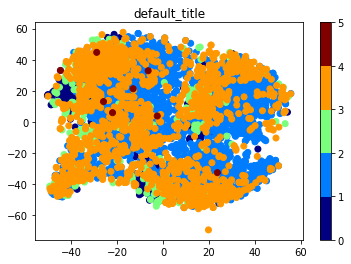

In [14]:
results_dir = join('..', '..', 'results')
plot_tSNE(feat_matrix, labels, path=results_dir)

## 2. Calculate features on the test data


This procedure is similar as for the training data, except that we do not know the labels and the folder with test images is not subdivided by material

In [33]:
def calculate_features_test(test_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features']
    df_features = pd.DataFrame(columns=columns)

    # Walk through all images
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            img_fp = join(root, file)
            id = file.split('.')[0]
            print("Calculate features for", id)

            # Pad if size is too small, preprocess
            img = image.load_img(img_fp, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)

            # Compute features 
            features = model.predict(img_data)
            features_np = np.array(features).flatten()

            df_features = df_features.append({'id': id ,
                                              'features': features_np},
                                             ignore_index=True)

    return df_features

In [34]:
features_test = calculate_features_test(test_dir)

Calculate features for 7a4ca23a
Calculate features for 7a4a091c
Calculate features for 7a4aba6a
Calculate features for 7a500c04
Calculate features for 7a46f132
Calculate features for 7a4c1ba8
Calculate features for 7a46f614
Calculate features for 7a495af8
Calculate features for 7a4d8a7e
Calculate features for 7a44da50
Calculate features for 7a517ee0
Calculate features for 7a4f76ea
Calculate features for 7a475884
Calculate features for 7a45e166
Calculate features for 7a49e298
Calculate features for 7a511ef0
Calculate features for 7a4e92a2
Calculate features for 7a51dff2
Calculate features for 7a4f9dfa
Calculate features for 7a4d1698
Calculate features for 7a497eac
Calculate features for 7a4ab100
Calculate features for 7a487d68
Calculate features for 7a4fbe20
Calculate features for 7a4f719a
Calculate features for 7a4e52d8
Calculate features for 7a4d6e72
Calculate features for 7a460510
Calculate features for 7a45c096
Calculate features for 7a4e60ac
Calculate features for 7a510848
Calculat

Calculate features for 7a4d19e0
Calculate features for 7a51eab0
Calculate features for 7a4683c8
Calculate features for 7a4c42cc
Calculate features for 7a51a21c
Calculate features for 7a4812c4
Calculate features for 7a47adac
Calculate features for 7a4e297a
Calculate features for 7a48e6a4
Calculate features for 7a4f73ac
Calculate features for 7a4ec72c
Calculate features for 7a481620
Calculate features for 7a4c425e
Calculate features for 7a4cbed2
Calculate features for 7a4f85fe
Calculate features for 7a502eb4
Calculate features for 7a491e08
Calculate features for 7a4b321a
Calculate features for 7a5006be
Calculate features for 7a450df4
Calculate features for 7a4c1e14
Calculate features for 7a4754b0
Calculate features for 7a50ff38
Calculate features for 7a4af156
Calculate features for 7a44f0d0
Calculate features for 7a4e3758
Calculate features for 7a4f5c3c
Calculate features for 7a46c48c
Calculate features for 7a494608
Calculate features for 7a46ad08
Calculate features for 7a4ebe9e
Calculat

Calculate features for 7a4de42e
Calculate features for 7a4a7ea6
Calculate features for 7a489c3a
Calculate features for 7a50660e
Calculate features for 7a4ad220
Calculate features for 7a513df4
Calculate features for 7a5022fc
Calculate features for 7a51b05e
Calculate features for 7a475280
Calculate features for 7a46bf28
Calculate features for 7a489b5e
Calculate features for 7a4c1e78
Calculate features for 7a48453c
Calculate features for 7a49b660
Calculate features for 7a4b385a
Calculate features for 7a4881fa
Calculate features for 7a515f96
Calculate features for 7a4fb8e4
Calculate features for 7a51756c
Calculate features for 7a505dee
Calculate features for 7a515bea
Calculate features for 7a4d1486
Calculate features for 7a4ba6e6
Calculate features for 7a519e5c
Calculate features for 7a4be8fe
Calculate features for 7a517012
Calculate features for 7a506a96
Calculate features for 7a49ff30
Calculate features for 7a4655b0
Calculate features for 7a50a65a
Calculate features for 7a51217a
Calculat

Calculate features for 7a49d3fc
Calculate features for 7a51c698
Calculate features for 7a4f9b20
Calculate features for 7a45f7dc
Calculate features for 7a501780
Calculate features for 7a513552
Calculate features for 7a49b8ea
Calculate features for 7a51a3ca
Calculate features for 7a4a4396
Calculate features for 7a48903c
Calculate features for 7a4d6724
Calculate features for 7a4fdfc2
Calculate features for 7a51a6a4
Calculate features for 7a49afc6
Calculate features for 7a466e9c
Calculate features for 7a47b568
Calculate features for 7a5089e0
Calculate features for 7a4ac8f2
Calculate features for 7a4abcc2
Calculate features for 7a462a0e
Calculate features for 7a51e1a0
Calculate features for 7a4e8c1c
Calculate features for 7a4becaa
Calculate features for 7a4f88ce
Calculate features for 7a451812
Calculate features for 7a4bbd84
Calculate features for 7a4653f8
Calculate features for 7a4ea8dc
Calculate features for 7a483952
Calculate features for 7a4bac36
Calculate features for 7a4aff52
Calculat

Calculate features for 7a4a1ad8
Calculate features for 7a516b12
Calculate features for 7a4dfac2
Calculate features for 7a4d26e2
Calculate features for 7a502a4a
Calculate features for 7a48e424
Calculate features for 7a480cb6
Calculate features for 7a4ed316
Calculate features for 7a46732e
Calculate features for 7a50b06e
Calculate features for 7a4eee82
Calculate features for 7a4d12ec
Calculate features for 7a4c887c
Calculate features for 7a4e0224
Calculate features for 7a4d7016
Calculate features for 7a500c72
Calculate features for 7a504872
Calculate features for 7a4811e8
Calculate features for 7a50711c
Calculate features for 7a504944
Calculate features for 7a46c91e
Calculate features for 7a517e0e
Calculate features for 7a48b102
Calculate features for 7a466154
Calculate features for 7a49b5f2
Calculate features for 7a4be4ee
Calculate features for 7a4b8256
Calculate features for 7a4adfb8
Calculate features for 7a4da432
Calculate features for 7a469728
Calculate features for 7a51a80c
Calculat

Calculate features for 7a44e608
Calculate features for 7a4eefc2
Calculate features for 7a4ce768
Calculate features for 7a508508
Calculate features for 7a509ae8
Calculate features for 7a50a452
Calculate features for 7a452776
Calculate features for 7a4f1b00
Calculate features for 7a4c786e
Calculate features for 7a4840c8
Calculate features for 7a50e638
Calculate features for 7a47e0e2
Calculate features for 7a500178
Calculate features for 7a4954c2
Calculate features for 7a4a2e38
Calculate features for 7a51c558
Calculate features for 7a4dde16
Calculate features for 7a45f69c
Calculate features for 7a4eb368
Calculate features for 7a45115a
Calculate features for 7a501abe
Calculate features for 7a48811e
Calculate features for 7a48b382
Calculate features for 7a49312c
Calculate features for 7a465038
Calculate features for 7a47a140
Calculate features for 7a4af71e
Calculate features for 7a4828ae
Calculate features for 7a517d3c
Calculate features for 7a4bd26a
Calculate features for 7a498be0
Calculat

Calculate features for 7a4e9ae0
Calculate features for 7a5093fe
Calculate features for 7a4b7e46
Calculate features for 7a50f7e0
Calculate features for 7a510500
Calculate features for 7a4f3680
Calculate features for 7a50de7c
Calculate features for 7a499482
Calculate features for 7a506e4c
Calculate features for 7a4edda2
Calculate features for 7a4b4656
Calculate features for 7a4dcb06
Calculate features for 7a46a330
Calculate features for 7a4f512e
Calculate features for 7a4c3eb2
Calculate features for 7a50b1a4
Calculate features for 7a4d4460
Calculate features for 7a4ccdaa
Calculate features for 7a4fe77e
Calculate features for 7a4ac744
Calculate features for 7a4a9a6c
Calculate features for 7a457fbe
Calculate features for 7a4edee2
Calculate features for 7a4b42aa
Calculate features for 7a50e91c
Calculate features for 7a4ad3c4
Calculate features for 7a4b0a42
Calculate features for 7a44e752
Calculate features for 7a507ce8
Calculate features for 7a45ee72
Calculate features for 7a4b752c
Calculat

Calculate features for 7a4a4256
Calculate features for 7a4dfed2
Calculate features for 7a4e2c54
Calculate features for 7a4be692
Calculate features for 7a44fc60
Calculate features for 7a500e70
Calculate features for 7a48c408
Calculate features for 7a4b6b54
Calculate features for 7a4de708
Calculate features for 7a49cbd2
Calculate features for 7a4a6d26
Calculate features for 7a4616fe
Calculate features for 7a4cfc44
Calculate features for 7a49888e
Calculate features for 7a50acd6
Calculate features for 7a45aa8e
Calculate features for 7a455aac
Calculate features for 7a477288
Calculate features for 7a484884
Calculate features for 7a452244
Calculate features for 7a4d31e6
Calculate features for 7a4500d4
Calculate features for 7a4be5c0
Calculate features for 7a4ca848
Calculate features for 7a4f6f88
Calculate features for 7a49617e
Calculate features for 7a47285a
Calculate features for 7a506816
Calculate features for 7a49305a
Calculate features for 7a5162d4
Calculate features for 7a4f2f3c
Calculat

Calculate features for 7a45e0da
Calculate features for 7a4b09de
Calculate features for 7a480914
Calculate features for 7a4f4f26
Calculate features for 7a494d6a
Calculate features for 7a4f2668
Calculate features for 7a4e2344
Calculate features for 7a46a9c0
Calculate features for 7a4b7b58
Calculate features for 7a48965e
Calculate features for 7a454ecc
Calculate features for 7a4bbe56
Calculate features for 7a4d1ab2
Calculate features for 7a49119c
Calculate features for 7a4c5e88
Calculate features for 7a4fb11e
Calculate features for 7a4f151a
Calculate features for 7a51d3ea
Calculate features for 7a45f4e4
Calculate features for 7a4b27d4
Calculate features for 7a4622e8
Calculate features for 7a4ec808
Calculate features for 7a4ded34
Calculate features for 7a51e68c
Calculate features for 7a4852c0
Calculate features for 7a50f646
Calculate features for 7a490df0
Calculate features for 7a4d17c4
Calculate features for 7a50f3d0
Calculate features for 7a4afd4a
Calculate features for 7a4919e4
Calculat

In [35]:
features_test.head()

,id,features
0,7a4ca23a,"[0.31079346, 0.17816938, 0.054394152, 0.022890..."
1,7a4a091c,"[0.08018307, 0.94980395, 0.23601931, 0.0033451..."
2,7a4aba6a,"[0.3590907, 0.34999856, 1.0970749, 0.036871217..."
3,7a500c04,"[0.26767585, 0.35573968, 0.032697484, 0.0, 0.0..."
4,7a46f132,"[0.81343603, 0.2503583, 0.0, 0.0, 0.11187569, ..."


In [36]:
import pickle
pickle_path = join('..', '..', 'pickles')
with open(join(pickle_path, 'resnet50_avg_features_' + region + '_test.pkl' ), 'wb') as f:
    pickle.dump(features_test, f)